# Baseline testing

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import _testing

In [3]:
## Constant
RANDOM_STATE = 0

## Data preparation

In [4]:
## Read csv file
df = pd.read_csv('train_all_tasks.csv')

### train/dev/test split

In [5]:
# text and labels for task A
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(df['text'], df['label_sexist'], test_size=0.3, random_state=RANDOM_STATE)
X_test_a, X_dev_a, y_test_a, y_dev_a = train_test_split(X_test_a, y_test_a, test_size=0.33, random_state=RANDOM_STATE)

# text and labels for task B
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(df[df['label_sexist'] == 'sexist']['text'],
                                                               df[df['label_sexist'] == 'sexist']['label_category'],
                                                               test_size=0.3,
                                                               random_state=RANDOM_STATE)
X_test_b, X_dev_b, y_test_b, y_dev_b = train_test_split(X_test_b, y_test_b, test_size=0.33, random_state=RANDOM_STATE)

In [6]:
## Printing the label distribution for Task A and B
print(Counter(y_train_a))
print(Counter(y_dev_a))
print(Counter(y_test_a))
print("")
print(Counter(y_train_b))
print(Counter(y_dev_b))
print(Counter(y_test_b))

Counter({'not sexist': 7413, 'sexist': 2387})
Counter({'not sexist': 1058, 'sexist': 328})
Counter({'not sexist': 2131, 'sexist': 683})

Counter({'2. derogation': 1107, '3. animosity': 812, '1. threats, plans to harm and incitement': 231, '4. prejudiced discussions': 228})
Counter({'2. derogation': 157, '3. animosity': 115, '4. prejudiced discussions': 37, '1. threats, plans to harm and incitement': 28})
Counter({'2. derogation': 326, '3. animosity': 238, '4. prejudiced discussions': 68, '1. threats, plans to harm and incitement': 51})


### Output formatting

In [7]:
def confmatrix_display(confmatrix, model_name, task_name):
    """This function takes an sklearn confusion matrix to generate a graphical plot, which is
    customized to fit the current task."""
    plt.rcParams.update({'font.size': 12})
    plt.figure(dpi=1200)

    if task_name == 'taskA':
        labels = df['label_sexist'].unique() 
    else:
        labels = df[df['label_sexist'] == 'sexist']['label_category'].sort_values().unique()
        labels[0] = '1. threats...'

    cm_display = ConfusionMatrixDisplay(confmatrix, display_labels=labels).plot()
    # cm_display = ConfusionMatrixDisplay(confmatrix).plot()
    
    if task_name != 'taskA':
        plt.xticks(rotation=45, ha='right')

In [8]:
def report(model_name, ydev, pred, task_name, zero_division=1):
    """This function takes the model name, prediction, and gold standard, 
    and prints a formatted report and confusion matrix based on this data."""
    conf_matrix = confusion_matrix(ydev, pred)
    print("\n=== {0} ===\n\nClassification Report:\n{1}"
          "\nConfusion Matrix:\n{2}".format(model_name,
                                            classification_report(ydev, pred, digits=4, 
                                                                  zero_division=zero_division),
                                            confusion_matrix(ydev, pred)))

    confmatrix_display(conf_matrix, model_name, task_name)

### Model setup

In [9]:
def naive_bayes(xtrain, ytrain, xdev, ydev, le, task_name):
  """This function trains a Naive Bayes model and predicts the labels on a test set, 
  which it prints the classification report and confusion matrix for by calling the report function."""
  model_name = "naive bayes"
  model = MultinomialNB()
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

In [10]:
def svm_train(xtrain, ytrain, xdev, ydev, le, task_name):
  """This function trains a linear SVM model and predicts the labels on a test set, 
  which it prints the classification report and confusion matrix for by calling the report function."""
  model_name = "SVM"
  model = SVC(kernel='linear', random_state=RANDOM_STATE)
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

In [11]:
def majority_class(xtrain, ytrain, xdev, ydev, le, task_name):
  """This function runs a Dummy classifier with the majority class to simulate the outcomes
  if the majority class label is used for all possible texts in a test set to 'predict' the labels, 
  which it prints the classification report and confusion matrix for by calling the report function."""
  model_name = "majority class"
  model = DummyClassifier(random_state=RANDOM_STATE)
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name, zero_division=0)

In [12]:
def decision_tree_train(xtrain, ytrain, xdev, ydev, le, task_name):
  """This function trains a Decision Tree model and predicts the labels on a test set, 
  which it prints the classification report and confusion matrix for by calling the report function."""
  model_name = "decision tree"
  model = DecisionTreeClassifier(random_state=RANDOM_STATE)
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

In [13]:
@_testing.ignore_warnings(category=ConvergenceWarning)
def logistic_regression(xtrain, ytrain, xdev, ydev, le, task_name):
  """This function trains a Logistic Regression model and predicts the labels on a test set, 
  which it prints the classification report and confusion matrix for by calling the report function."""
  model_name = "logistic regression"
  model = LogisticRegression(random_state=RANDOM_STATE)
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

In [14]:
from sklearn.ensemble import StackingClassifier

@_testing.ignore_warnings(category=ConvergenceWarning)
def stacking_classifier(xtrain, ytrain, xdev, ydev, le, task_name):
  """This function trains an ensemble classifier containing a decision tree, SVC (SVM),
  Naive Bayes, and Logistic regression. It predicts the labels on a test set, 
  which it prints the classification report and confusion matrix for by calling the report function."""
  model_name = "stacking classifier"

  estimators = [('dt', DecisionTreeClassifier(random_state=RANDOM_STATE)),
                ('svc', SVC(kernel='linear', random_state=RANDOM_STATE)),
                ('nb', MultinomialNB()),
                ('lr', LogisticRegression(random_state=RANDOM_STATE))]
  model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=RANDOM_STATE))


  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

## Running Task A (Binary) 

In [15]:
task_name = 'taskA'
le = LabelEncoder()

le.fit(y_train_a)
y_train_a = le.transform(y_train_a)

### Naive Bayes


=== naive bayes ===

Classification Report:
              precision    recall  f1-score   support

  not sexist     0.8198    0.9521    0.8810      2131
      sexist     0.6991    0.3470    0.4638       683

    accuracy                         0.8053      2814
   macro avg     0.7595    0.6496    0.6724      2814
weighted avg     0.7905    0.8053    0.7798      2814

Confusion Matrix:
[[2029  102]
 [ 446  237]]


<Figure size 7680x5760 with 0 Axes>

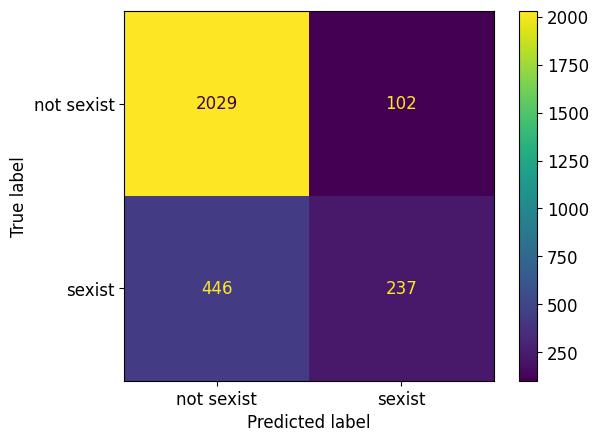

In [16]:
naive_bayes(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

### Majority class


=== majority class ===

Classification Report:
              precision    recall  f1-score   support

  not sexist     0.7573    1.0000    0.8619      2131
      sexist     0.0000    0.0000    0.0000       683

    accuracy                         0.7573      2814
   macro avg     0.3786    0.5000    0.4309      2814
weighted avg     0.5735    0.7573    0.6527      2814

Confusion Matrix:
[[2131    0]
 [ 683    0]]


<Figure size 7680x5760 with 0 Axes>

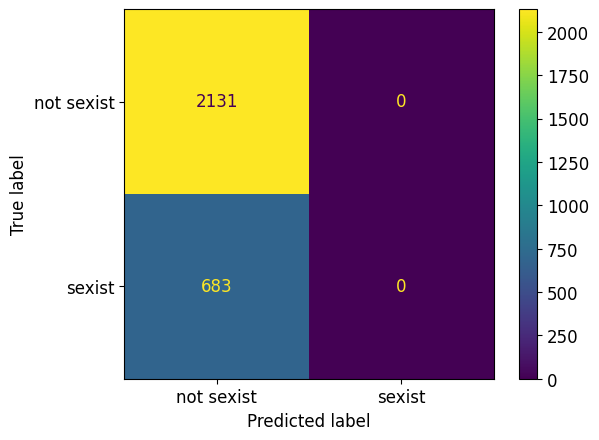

In [17]:
majority_class(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

### SVM


=== SVM ===

Classification Report:
              precision    recall  f1-score   support

  not sexist     0.8581    0.8911    0.8743      2131
      sexist     0.6140    0.5403    0.5748       683

    accuracy                         0.8060      2814
   macro avg     0.7360    0.7157    0.7245      2814
weighted avg     0.7989    0.8060    0.8016      2814

Confusion Matrix:
[[1899  232]
 [ 314  369]]


<Figure size 7680x5760 with 0 Axes>

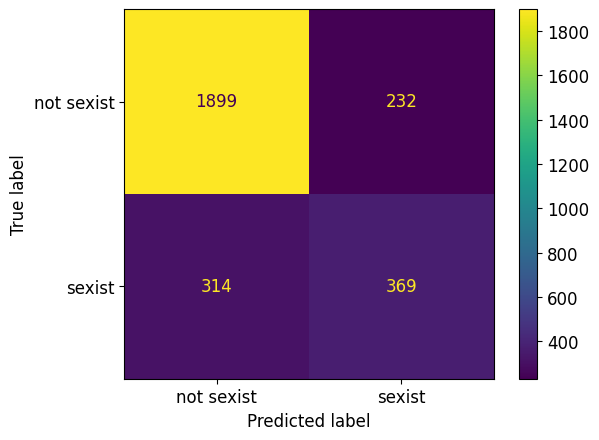

In [18]:
svm_train(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

### Decision tree


=== decision tree ===

Classification Report:
              precision    recall  f1-score   support

  not sexist     0.8553    0.8846    0.8697      2131
      sexist     0.5967    0.5329    0.5630       683

    accuracy                         0.7992      2814
   macro avg     0.7260    0.7088    0.7163      2814
weighted avg     0.7925    0.7992    0.7952      2814

Confusion Matrix:
[[1885  246]
 [ 319  364]]


<Figure size 7680x5760 with 0 Axes>

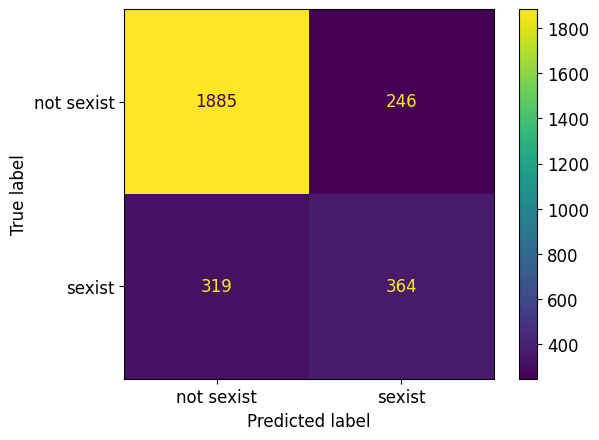

In [19]:
decision_tree_train(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

### Logistic regression


=== logistic regression ===

Classification Report:
              precision    recall  f1-score   support

  not sexist     0.8504    0.9390    0.8925      2131
      sexist     0.7180    0.4846    0.5787       683

    accuracy                         0.8287      2814
   macro avg     0.7842    0.7118    0.7356      2814
weighted avg     0.8183    0.8287    0.8163      2814

Confusion Matrix:
[[2001  130]
 [ 352  331]]


<Figure size 7680x5760 with 0 Axes>

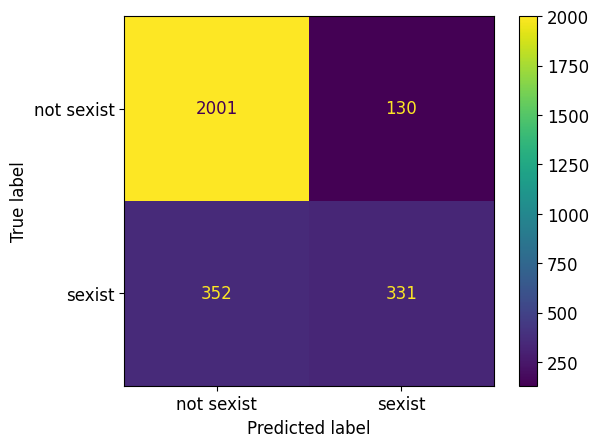

In [20]:
logistic_regression(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

### Stacking classifier


=== stacking classifier ===

Classification Report:
              precision    recall  f1-score   support

  not sexist     0.8508    0.9526    0.8988      2131
      sexist     0.7640    0.4788    0.5887       683

    accuracy                         0.8376      2814
   macro avg     0.8074    0.7157    0.7437      2814
weighted avg     0.8297    0.8376    0.8235      2814

Confusion Matrix:
[[2030  101]
 [ 356  327]]


<Figure size 7680x5760 with 0 Axes>

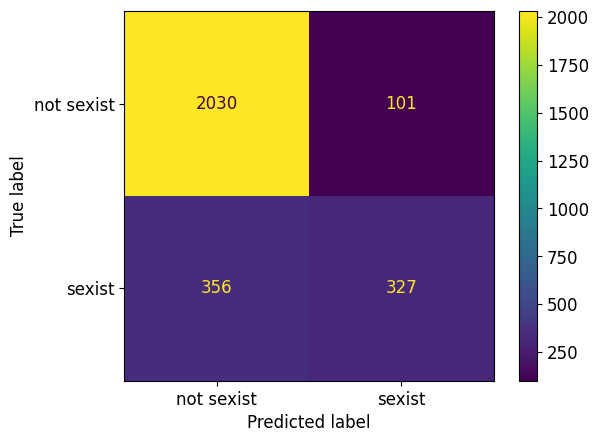

In [21]:
stacking_classifier(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

## Running Task B (Multi-class) 

In [22]:
task_name = 'taskB'

le.fit(y_train_b)
y_train_b = le.transform(y_train_b)

### Naive Bayes


=== naive bayes ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement     1.0000    0.0980    0.1786        51
                           2. derogation     0.5250    0.8374    0.6454       326
                            3. animosity     0.4610    0.2983    0.3622       238
               4. prejudiced discussions     0.7500    0.0441    0.0833        68

                                accuracy                         0.5154       683
                               macro avg     0.6840    0.3195    0.3174       683
                            weighted avg     0.5606    0.5154    0.4559       683

Confusion Matrix:
[[  5  32  14   0]
 [  0 273  52   1]
 [  0 167  71   0]
 [  0  48  17   3]]


<Figure size 7680x5760 with 0 Axes>

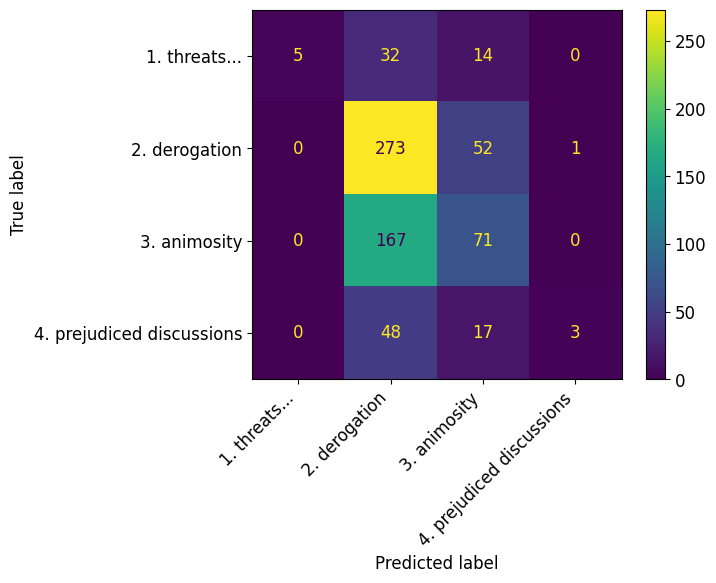

In [23]:
naive_bayes(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)

### Majority class


=== majority class ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement     0.0000    0.0000    0.0000        51
                           2. derogation     0.4773    1.0000    0.6462       326
                            3. animosity     0.0000    0.0000    0.0000       238
               4. prejudiced discussions     0.0000    0.0000    0.0000        68

                                accuracy                         0.4773       683
                               macro avg     0.1193    0.2500    0.1615       683
                            weighted avg     0.2278    0.4773    0.3084       683

Confusion Matrix:
[[  0  51   0   0]
 [  0 326   0   0]
 [  0 238   0   0]
 [  0  68   0   0]]


<Figure size 7680x5760 with 0 Axes>

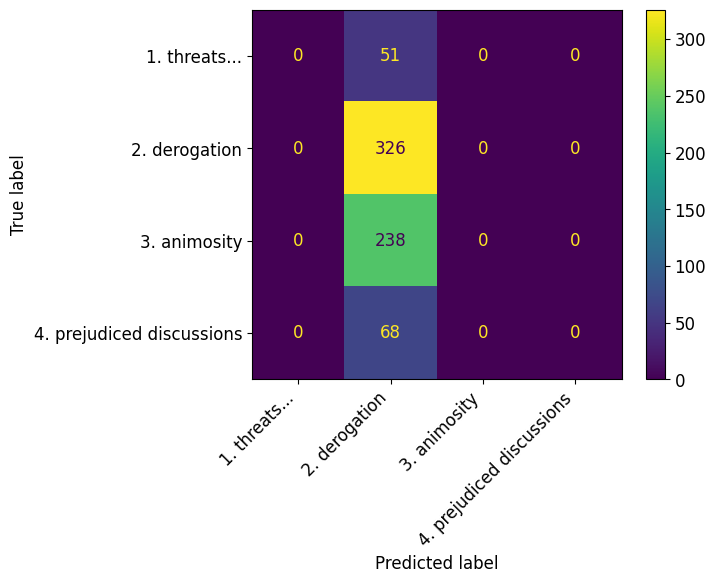

In [24]:
majority_class(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)

### SVM


=== SVM ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement     0.3857    0.5294    0.4463        51
                           2. derogation     0.5522    0.5675    0.5598       326
                            3. animosity     0.4402    0.4328    0.4364       238
               4. prejudiced discussions     0.2727    0.1765    0.2143        68

                                accuracy                         0.4788       683
                               macro avg     0.4127    0.4265    0.4142       683
                            weighted avg     0.4729    0.4788    0.4739       683

Confusion Matrix:
[[ 27   7  12   5]
 [ 26 185 100  15]
 [ 13 110 103  12]
 [  4  33  19  12]]


<Figure size 7680x5760 with 0 Axes>

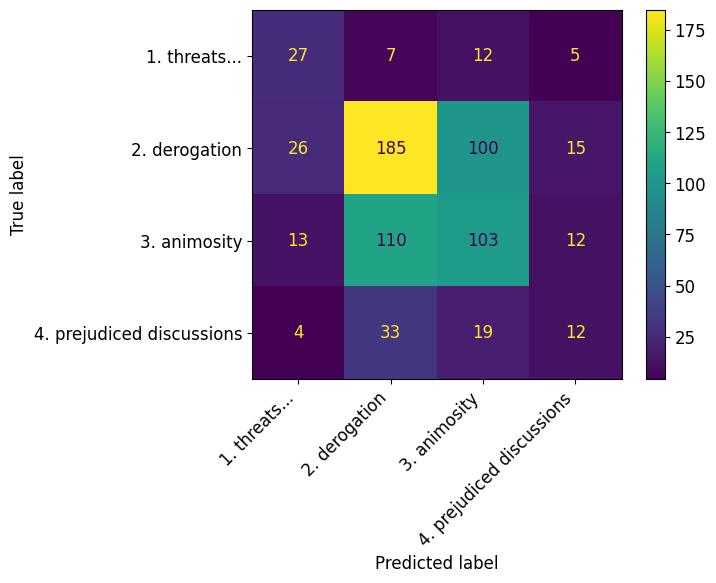

In [25]:
svm_train(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)

### Decision tree


=== decision tree ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement     0.2642    0.2745    0.2692        51
                           2. derogation     0.5347    0.5429    0.5388       326
                            3. animosity     0.4723    0.4664    0.4693       238
               4. prejudiced discussions     0.1875    0.1765    0.1818        68

                                accuracy                         0.4597       683
                               macro avg     0.3647    0.3651    0.3648       683
                            weighted avg     0.4582    0.4597    0.4589       683

Confusion Matrix:
[[ 14  19  13   5]
 [ 19 177  95  35]
 [ 16  99 111  12]
 [  4  36  16  12]]


<Figure size 7680x5760 with 0 Axes>

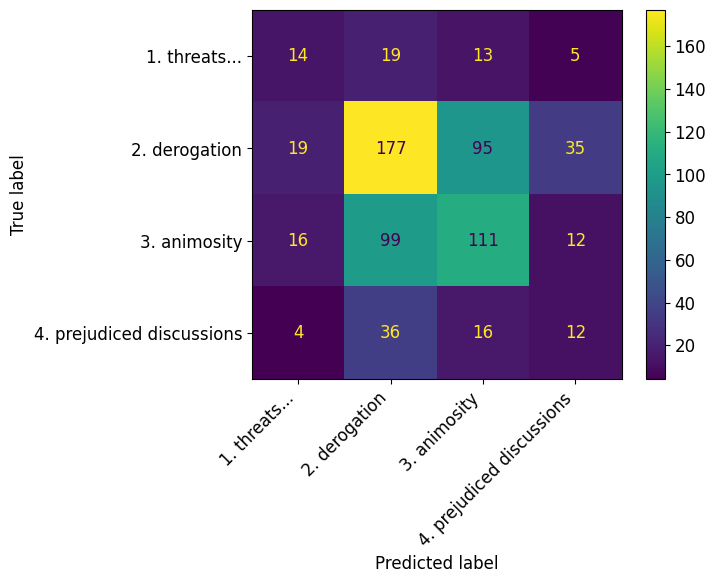

In [26]:
decision_tree_train(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)

### Logistic regression


=== logistic regression ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement     0.5238    0.4314    0.4731        51
                           2. derogation     0.5699    0.6380    0.6020       326
                            3. animosity     0.4622    0.4622    0.4622       238
               4. prejudiced discussions     0.3158    0.1765    0.2264        68

                                accuracy                         0.5154       683
                               macro avg     0.4679    0.4270    0.4409       683
                            weighted avg     0.5036    0.5154    0.5063       683

Confusion Matrix:
[[ 22   9  15   5]
 [ 12 208  97   9]
 [  5 111 110  12]
 [  3  37  16  12]]


<Figure size 7680x5760 with 0 Axes>

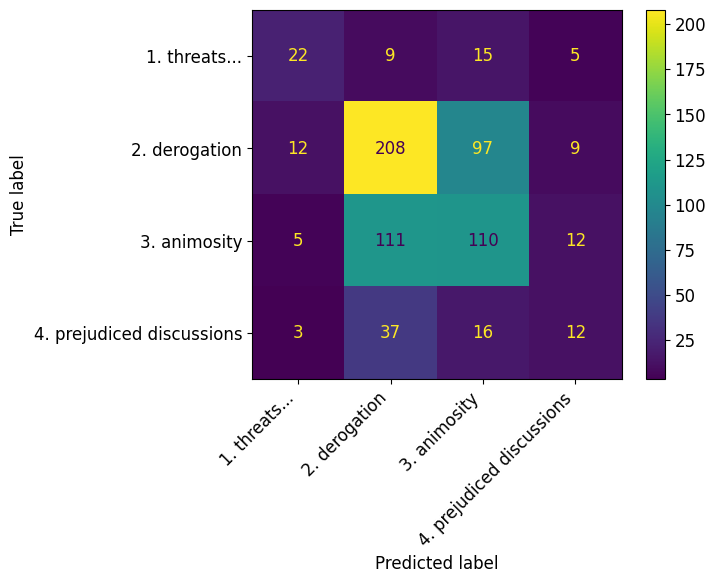

In [27]:
logistic_regression(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)

### Stacking classifier


=== stacking classifier ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement     0.5405    0.3922    0.4545        51
                           2. derogation     0.5422    0.7883    0.6425       326
                            3. animosity     0.5000    0.2941    0.3704       238
               4. prejudiced discussions     0.2812    0.1324    0.1800        68

                                accuracy                         0.5212       683
                               macro avg     0.4660    0.4017    0.4119       683
                            weighted avg     0.5014    0.5212    0.4876       683

Confusion Matrix:
[[ 20  18   8   5]
 [  9 257  51   9]
 [  5 154  70   9]
 [  3  45  11   9]]


<Figure size 7680x5760 with 0 Axes>

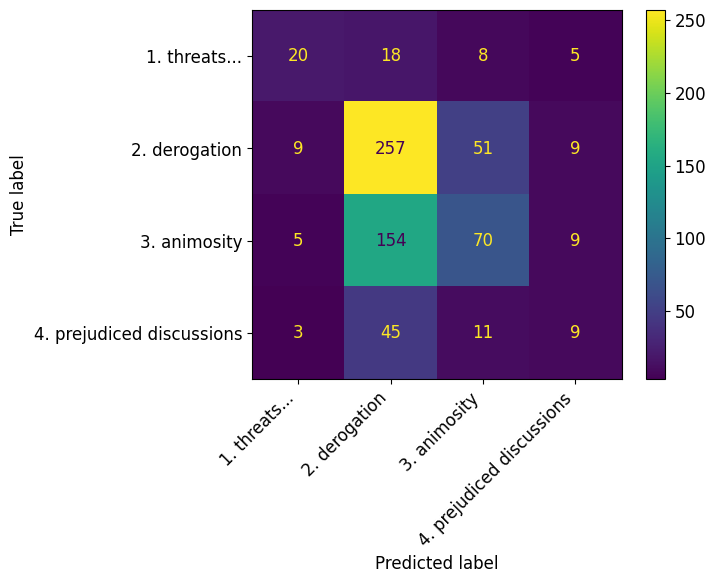

In [28]:
stacking_classifier(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)